In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from base_hTCN import base_hTCN
from sklearn import metrics
import torch.distributions as dist



# Hyperparams

In [2]:
train_T = 65000
test_T = 15000
T_no = 100
M_no = 1
B_no = 2

C_den = torch.zeros(5,5)
C_den[0,1:] = 1

#C_den = torch.tensor([0]).reshape((1,1))



sub_no = C_den.shape[0]

batch_size = 2000

In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
#Ensyn = torch.tensor([106+213+211+99])
#Insyn = torch.tensor([1+22+36+42+19])

E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]
    
#######
#####
#C_syn = torch.hstack((C_syn_e, C_syn_i))

# Train

In [4]:
model = base_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)

model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.npy").flatten()[:]
#V_ref = np.fromfile("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
#V_ref = V_ref[1:]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([15000])


In [5]:
state_dict = model.state_dict()

for name, param in state_dict.items():
    # Transform the parameter as required.
    transformed_param = param * 0.25
    # Update the parameter.
    state_dict[name].copy_(transformed_param)

In [6]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

#######
#######
#train_S = torch.hstack((train_S_E, train_S_I)).float()
#test_S = torch.hstack((test_S_E, test_S_I)).float().cuda()

In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

126000
126000


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)


435


In [9]:
#batch_no = 10000
loss_array = np.empty((batch_no//100, 2))
#criterion = nn.MSELoss(reduction="mean")

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    #batch_S = train_S[batch_idx : batch_idx+batch_size].cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].float().cuda()

    loss = torch.var(batch_pred - batch_ref.flatten())
    #loss = torch.mean((batch_pred -  batch_ref) ** 2)
    
    loss = loss 
    
    loss.backward()
    #for name, p in model.named_parameters():
        #print(name, p.grad)

    
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        #test_loss = torch.mean((test_V_ref - test_pred) ** 2)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        #if i%100 == 0:
            #torch.save(model.state_dict(), "/media/hdd01/sklee/tcn/burst_L23_sub5_m2_i"+str(i)+".pt")
            #loss_array[i//100,0] = i
            #loss_array[i//100,1] = test_score
            #np.save("/media/hdd01/sklee/tcn/burst_L23_sub5_m2_test_scores.npy", loss_array)


<ipython-input-9-d71015c8eb4c>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 20.271186816339046 0.0030250196068684065 -0.01649940013885498
TEST 100 20.30305106849026 0.001457875921428764 0.0012900233268737793
TEST 200 20.133362104812296 0.009803497369818892 -0.005943417549133301
TEST 300 17.19994401813924 0.15407449976825627 -0.017456889152526855
TEST 400 15.462301117027113 0.23953503611338944 0.18875855207443237
TEST 500 14.404893899762039 0.29154030585737234 0.22123360633850098
TEST 600 13.737357692994957 0.32437098830743827 0.039139747619628906
TEST 700 13.374447375102989 0.3422195983018157 0.3400604724884033
TEST 800 12.839996766811469 0.36850488133544135 0.3698996901512146
TEST 900 12.547452437468898 0.38289276001063854 0.415743887424469
TEST 1000 12.036947753564823 0.4080003377035012 0.3889354467391968
TEST 1100 11.757995706603607 0.4217197224379535 0.41603153944015503
TEST 1200 11.533391624266052 0.432766172343211 0.31574034690856934
TEST 1300 11.231787880930383 0.44759961002400583 0.2125847339630127
TEST 1400 10.923159709919533 0.4627785222284667

TEST 12400 1.4796022539157732 0.9272303866290773 0.9235441088676453
TEST 12500 1.8190125427110109 0.9105375521798699 0.768939733505249
TEST 12600 1.438648841170386 0.929244552276808 0.7679687142372131
TEST 12700 1.5528073110632739 0.9236300246662921 0.7245055437088013
TEST 12800 1.5282940284693185 0.9248356338615695 0.8950232863426208
TEST 12900 1.9076594321797484 0.9061777319138805 0.8400265574455261
TEST 13000 1.4414932744733906 0.9291046577124633 0.9330503344535828
TEST 13100 1.4803898884449216 0.9271916493048656 0.8911916017532349
TEST 13200 1.4476807204586217 0.9288003475145185 0.8746392726898193
TEST 13300 1.4222901383224564 0.9300491039665133 0.9357273578643799
TEST 13400 1.401239747920076 0.9310844016412705 0.9141862392425537
TEST 13500 1.4622031149582935 0.9280861089301687 0.8544888496398926
TEST 13600 1.3396913192147213 0.9341114687845676 0.8061310648918152
TEST 13700 1.580967250223281 0.9222450660512235 0.8902634382247925
TEST 13800 1.3936217493871834 0.9314590690986226 0.91

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(test_V_ref.cpu().detach().numpy()[1000:5000], linewidth=1)
plt.plot(test_pred.cpu().detach().numpy()[1000:5000] - 78, linewidth=1)
plt.title("No APs: 0hz Burst")
#plt.ylim(-100,0)

#plt.savefig("/media/hdd01/sklee/tcn/Asoma_b4.png", dpi=150, bbox_inches='tight')#

torch.Size([5, 100])


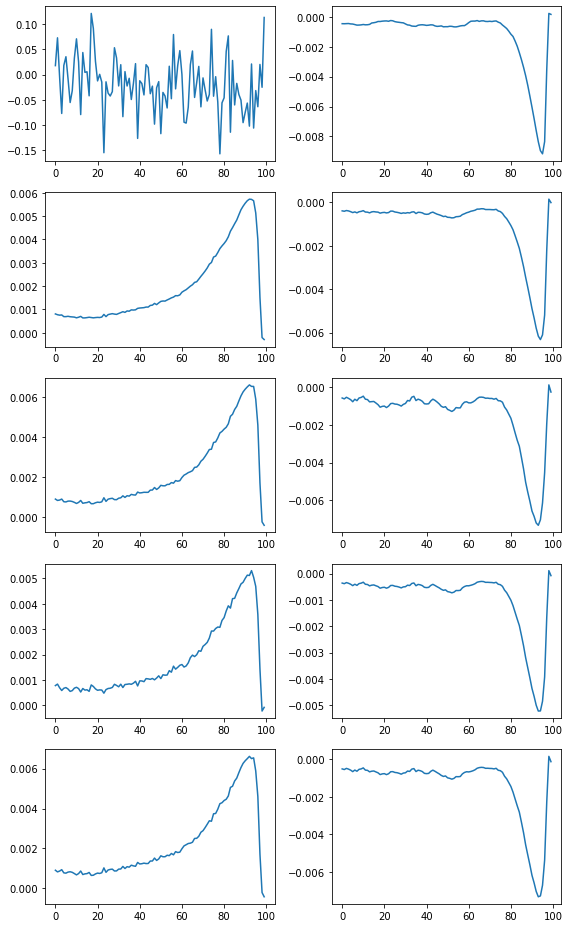

In [11]:
e_weights = torch.matmul(model.conv1_e_weights, model.conv1_e_bases)
i_weights = torch.matmul(model.conv1_i_weights, model.conv1_i_bases)
print(e_weights.shape)

fig, axs = plt.subplots(ncols=2, nrows=5, figsize = (8,13))
for row in range(5):
    axs[row, 0].plot(e_weights[row,:].cpu().detach().numpy())
    axs[row, 1].plot(i_weights[row,:].cpu().detach().numpy())
    
fig.tight_layout()
#plt.savefig("/media/hdd01/sklee/tcn/Adend_b0_filters.png", dpi=150, bbox_inches='tight')#

In [12]:
#e_weights = e_weights.cpu().detach().numpy()
for i in range(5):
    print(torch.argmax(e_weights[-i,:]))

tensor(17, device='cuda:0')
tensor(92, device='cuda:0')
tensor(93, device='cuda:0')
tensor(92, device='cuda:0')
tensor(92, device='cuda:0')
